## Handwritten optical character recognition

#### Importing necessary libraries

In [62]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt
from IPython.display import clear_output as cls
import seaborn as sns
import tensorflow as tf
import tensorflow.data as tfd
from keras.layers import *
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint 

#### Setting up variables

In [10]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 150
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 125
VALID_SIZE = BATCH_SIZE * 15
TEST_SIZE  = BATCH_SIZE * 15
AUTOTUNE = tfd.AUTOTUNE

# Training callbacks 
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath = MODEL_NAME + ".keras", save_best_only=True)
]

# Paths 
train_csv_path = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\written_name_train.csv"
valid_csv_path = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\written_name_validation.csv"
test_csv_path = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\written_name_test.csv"
train_image_dir = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\train"
valid_image_dir = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\validation"
test_image_dir = r"C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV internship\Handwriting\test"

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

### Data loading and Preprocessing
The datas are divided into 2 parts:

Labels and File paths
Images
There are some variables defined with csv_path at the end of their names. Those are the files that contain the labels and file paths for them.
The images are stored in the paths where their variables are defined with the ending of image_dir.
First the .csv files are loaded. After that the labels and their file paths get extracted. After that, the labels are processed and the images are loaded based on the file names of the labels. At the end the images also get preprocessed to be ready for getting feeded to the model.

In [11]:
# load the csv files 
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE] 

In [32]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [41]:
train_csv.head()

,FILENAME,IDENTITY
0,C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV ...,BALTHAZAR
1,C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV ...,SIMON
2,C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV ...,BENES
3,C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV ...,LA LOVE
4,C:\Users\msste\OneDrive\Coding\DA\Meduzzen CV ...,DAPHNE


In [33]:
# get the train labels 
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

In [34]:
# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

In [35]:
print(f"Number of unique classes(unique characters): {n_classes}")

Number of unique classes(unique characters): 44


In [36]:
# get the maximum length that a label can have 
MAX_LABEL_LENGTH = max(map(len, train_labels))

In [37]:
print(f"The length of the longest label in the datase: {MAX_LABEL_LENGTH}")

The length of the longest label in the datase: 24


In [38]:
#get the train labels 
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

# get the maximum length that a label can have 
MAX_LABEL_LENGTH = max(map(len, train_labels))

In [39]:
# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

### Image preprocessing
To Function must be used for image preprocessing part:
The first function is load_image. This function loads the images and returns the image as an numpy array.
The second function is used for both images and labels. It gets the data and returns the encoded versions of them.

In [40]:
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image usin TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [15]:
def encode_single_sample(image_path, label:str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    '''
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [56]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [57]:
# check the data distribution 
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 1000
Validation Data Size : 104
Testing Data Size    : 104


In [58]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

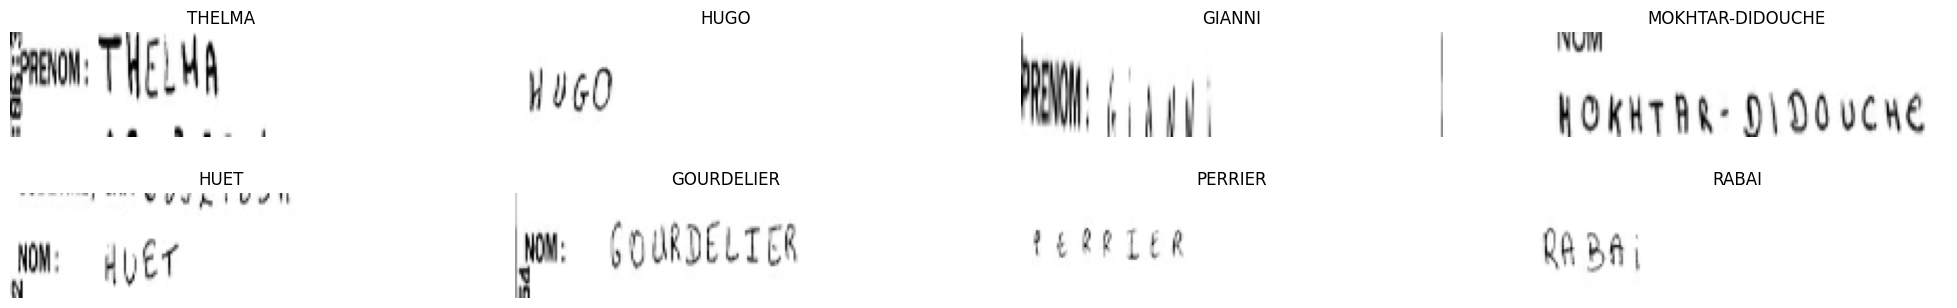

In [59]:
show_images(data=train_ds, cmap='gray')

### CTC Loss

The Connectionist Temporal Classification(CTC) loss is used for seq2seq tasks.
In this case, the CTC Loss will take the Predicted Sequence of Characters and the label and calculates how far are they from each other.
The other task of CTC is to align the the length of predicted sequence and the label by addin blank space



In [48]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len) 

        self.add_loss(loss)

        return y_hat

### Model Creation
The model used is a Encoder-Decoder Model which means it is a combinatio of CNN and RNN.

Model Architecture:
The model has 2 Convolutional layers followed by MaxPools.
The encoding space has one Dense layer. The Decoder network is consist of 2 Bidirectional LSTM layers.

In [49]:
# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



### Encoding 
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output) 

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

In [67]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 200, 50, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_1 (Conv2D)               │ (None, 200, 50, 64)       │             640 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_2 (Conv2D)               │ (None, 200, 50, 32)       │          18,464 │ conv_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 100, 25, 32)       │               0 │ conv_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_3 (Conv2D)               │ (None, 100, 25, 64)       │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_4 (Conv2D)               │ (None, 100, 25, 32)       │          18,464 │ conv_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 50, 12, 32)        │               0 │ conv_4[0][0]               │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_layer (Reshape)       │ (None, 50, 384)           │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ enconding_dense (Dense)       │ (None, 50, 64)            │          24,640 │ reshape_layer[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ enconding_dense_2 (Dense)     │ (None, 50, 64)            │           4,160 │ enconding_dense[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 50, 64)            │               0 │ enconding_dense_2[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_lstm_1          │ (None, 50, 256)           │         197,632 │ dropout[0][0]              │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_lstm_2          │ (None, 50, 128)           │         164,352 │ bidirectional_lstm_1[0][0] │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dense (Dense)          │ (None, 50, 46)            │           5,934 │ bidirectional_lstm_2[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_layer (CTCLayer)          │ (None, 50, 46)            │               

 Total params: 1,358,348 (5.18 MB)

 Trainable params: 452,782 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 905,566 (3.45 MB)

### Model Training

In [51]:
# compile the model
model.compile(optimizer="adam")

In [60]:
# train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS)

Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - loss: 20.2928 - val_loss: 20.4259
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 20.6046 - val_loss: 20.4188
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 20.5457 - val_loss: 20.3097
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - loss: 20.4874 - val_loss: 20.2888
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 20.3055 - val_loss: 20.2841
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 20.3344 - val_loss: 20.1264
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - loss: 20.0822 - val_loss: 20.0857
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - loss: 20.2687 - val_loss: 20.0519
Epoch 9/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - loss: 20.1699 - val_loss: 19.9924
Epoch 10/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - loss: 20.1427 - val_loss: 19.9120
Epoch 11/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - loss: 20.4785 - val_loss: 19.9088
Epoch 12

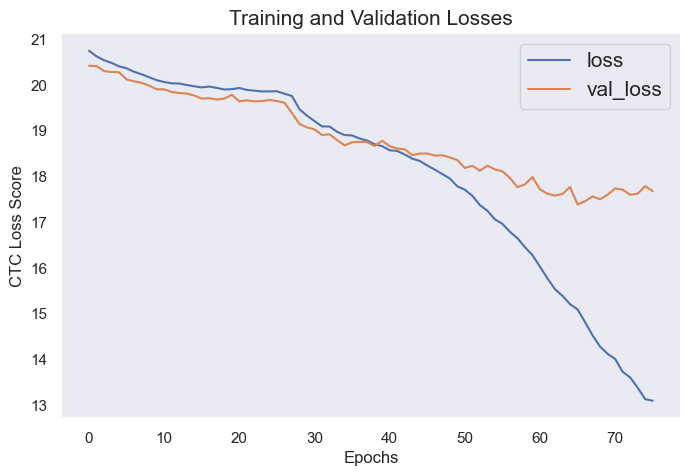

In [63]:
# draw plot for results 
sns.set()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()

### Testing and Evaluation

In [78]:
# evaluate the model on the test dataset 
evaluation = model.evaluate(test_ds)
print(f"evaluation loss: {evaluation}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 19.2720
evaluation loss: 18.715675354003906


In [64]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable. 
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [73]:
# define a model for testing and evaluation 
pred_model = Model(inputs=model.get_layer(name="image").output, outputs=model.get_layer(name='output_dense').output)

Making predictions

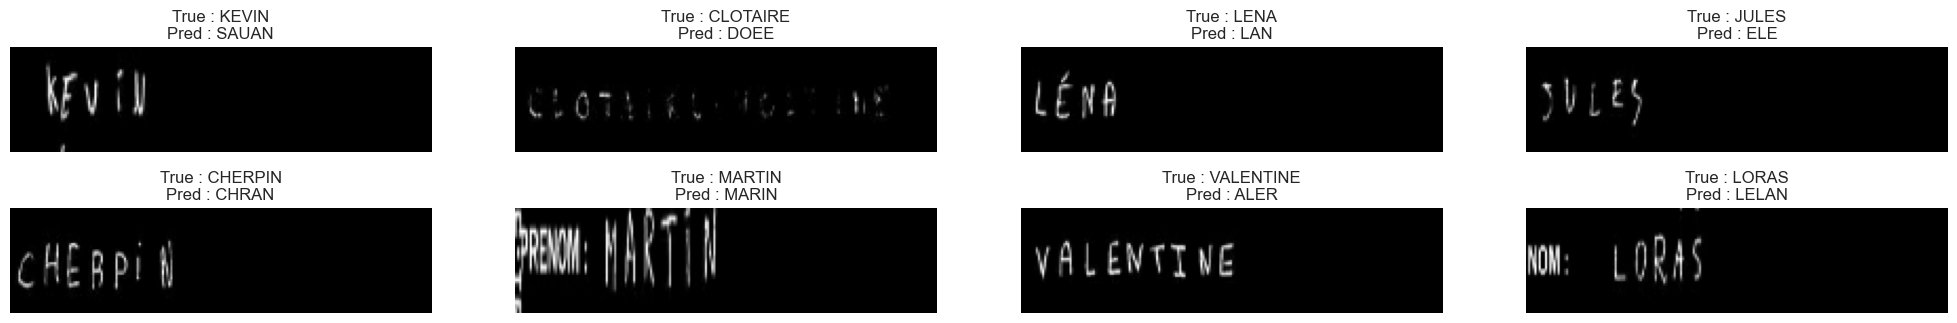

In [74]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')

### Saving the model

In [77]:
# save the model
model.save("handwriting_model.keras")
# save weights
model.save_weights("handwriting_model_weights.weights.h5")

### Conclusions
Due to limited computational ability, training data were limited resulting in poor predictions. However, model structure has proven to be valid and can be used for custom training.